# Text

In [333]:
import os
from pathlib import Path
import re
import tempfile
import requests

def acquire_shakespeare_dataset():
    temp_dir = tempfile.gettempdir()
    shakespeare_filepath = Path(temp_dir)/"shakespeare.txt"
    if not os.path.exists(shakespeare_filepath):
        data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
        with open(shakespeare_filepath, 'w', encoding='utf-8') as f:
            f.write(requests.get(data_url).text)
    
    with open(shakespeare_filepath, 'r', encoding='utf-8') as f:
        data = f.read()
    
    characters_lines = re.split(r"\n\s*\n", data.strip())
    MIN_WORDS_PER_BATCH = 250
    sample = [characters_lines[0]]
    num_words_in_sample = len(characters_lines[0].split())
    text_dataset = []
    i = 1
    while i < len(characters_lines[:100]):
        if num_words_in_sample > MIN_WORDS_PER_BATCH:
            text_dataset.append("\n\n".join(sample))
            num_words_in_sample -= len(sample[0].split())
            sample = sample[1:]
        sample += [characters_lines[i]]
        num_words_in_sample += len(characters_lines[i].split())
        i += 1

    return text_dataset

In [334]:
text_dataset = acquire_shakespeare_dataset()

In [335]:
print(f"Character length of first 3 samples: {[len(x) for x in text_dataset[:3]]}\n")
print(f"First 80 characters of first sample:\n\n{text_dataset[0][:80]}")

Character length of first 3 samples: [1632, 1688, 1891]

First 80 characters of first sample:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


## Tokenize text

In [4]:
import torch
from transformers import GPT2TokenizerFast

In [5]:
# Prefixing with _ to signify global.
_text_tokenizer = GPT2TokenizerFast.from_pretrained("openai-community/gpt2")
_text_tokenizer.pad_token = _text_tokenizer.eos_token
tokenize_text = _text_tokenizer

In [6]:
SEQUENCE_LENGTH = 1024
BATCH_SIZE=3

In [7]:
text_batch = tokenize_text(text_dataset[:BATCH_SIZE], max_length=SEQUENCE_LENGTH, truncation=True, padding="max_length", return_tensors="pt")
text_batch["input_ids"].shape, text_batch["attention_mask"].shape

(torch.Size([3, 1024]), torch.Size([3, 1024]))

## Sequence text

In [8]:
import torch.nn as nn

In [9]:
# All modalities need to be embedding with the same number of dimensions, since we'll be
# sending them all through the same model as part of the same batch.
#
# To keep our model small, we're going to use image embeddings of 12x12 patches.
# Thus, that's what our text modality will use also.
# 12 * 12 * 3 = 432
EMBEDDING_DIM = 432

In [10]:
_text_embedding = nn.Embedding(_text_tokenizer.vocab_size, EMBEDDING_DIM)
embed_text = _text_embedding

In [11]:
def sequence_text(tokenizer, embedder, max_length, batch):
    tokens = tokenizer(batch, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")
    ys = tokens["input_ids"].clone()[:, 1:]
    embedding = embedder(tokens["input_ids"][:, :-1])
    return embedding, ys, tokens["attention_mask"][:, :-1]

In [12]:
from torch.utils.data import DataLoader
from functools import partial

In [13]:
_text_tokenizer(next(iter(DataLoader(text_dataset, batch_size=BATCH_SIZE))));

In [14]:
text_dataloader = map(
    partial(sequence_text, tokenize_text, _text_embedding, SEQUENCE_LENGTH),
    DataLoader(text_dataset, batch_size=BATCH_SIZE)
)
text_xs, text_ys, text_mask = next(iter(text_dataloader))

In [336]:
text_xs.shape, text_ys.shape, text_mask.shape

(torch.Size([3, 1024, 432]), torch.Size([3, 1024]), torch.Size([3, 1024]))

# VQA

In [16]:
import datasets

In [17]:
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa").with_format(
    "torch"
)

In [18]:
import random
from torch.utils.data import default_collate

In [19]:
import torchvision.transforms.v2 as transforms

In [20]:
def _permute_channel_to_first(sample):
    sample["image"] = torch.permute(sample["image"], (2, 0, 1))
    return sample

micro_ok_vqa_transform = transforms.Compose([
    _permute_channel_to_first,    
    transforms.RandomResizedCrop((192, 192), (0.5, 1.0)),
])

In [21]:
def micro_ok_vqa_collate_fn(batch):
    answers = [random.choice(el["answers"])["answer"] for el in batch]
    questions = [el["question"] for el in batch]
    images = torch.stack([el["image"] for el in batch])
    return {
        "question": questions,
        "image": images,
        "answer": answers,
    }

In [22]:
# You can `.map(transforms)` over HuggingFace datasets.
vqa_dl = DataLoader(
    vqa_dataset["train"]
    .map(micro_ok_vqa_transform),
    batch_size=8,
    collate_fn=micro_ok_vqa_collate_fn,
)
vqa_batch = next(iter(vqa_dl))

In [23]:
vqa_batch["image"].shape

torch.Size([8, 3, 192, 192])

In [24]:
import matplotlib.pyplot as plt

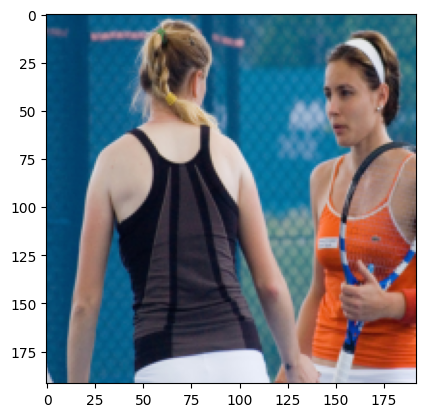

In [25]:
plt.imshow(vqa_batch["image"][0].permute(1, 2, 0))

### Tokenizing images - patches

In [26]:
images = vqa_batch["image"]
images.shape

torch.Size([8, 3, 192, 192])

In [27]:
from einops import rearrange

In [28]:
patch_size=12

In [29]:
patches = rearrange(images, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
patches.shape

torch.Size([8, 256, 432])

In [30]:
reconstructed = rearrange(patches, 'b (ph pw) (sh sw c) -> b c (ph sh) (pw sw)', ph=16, pw=16, sh=patch_size, sw=patch_size)
reconstructed.shape

torch.Size([8, 3, 192, 192])

In [31]:
(reconstructed == images).all()

tensor(True)

In [32]:
def images_to_patches(images, patch_size=12):
    return rearrange(images, 'b c (h s1) (w s2) -> b (h w) (c s1 s2)', s1=patch_size, s2=patch_size)

# We don't need this as part of Gato. It's just here to play with and visually test the code.
def patches_to_image(patches, image_shape, patch_size=12):
    channels, height, width = image_shape
    patch_height = height // patch_size
    patch_width = width // patch_size
    reconstructed = rearrange(
        patches, 
        'b (ph pw) (c ps1 ps2) -> b c (ph ps1) (pw ps2)',
        ph=patch_height,
        pw=patch_width,
        ps1=patch_size,
        ps2=patch_size,
    )
    return reconstructed

In [33]:
# And to prove that we can go from image -> patch -> image
recovered_images = patches_to_image(images_to_patches(images), (3, 192, 192))
(recovered_images == images).all()

tensor(True)

In [34]:
def normalize_to_between_minus_one_plus_one(t: torch.Tensor):
    min_val, max_val = t.min(), t.max()
    if min_val == max_val:
        return torch.zeros_like(t)
    normalized = 2 * (t - min_val) / (max_val - min_val) - 1
    return normalized

In [35]:
normalize_to_between_minus_one_plus_one(torch.arange(6))

tensor([-1.0000, -0.6000, -0.2000,  0.2000,  0.6000,  1.0000])

In [36]:
# There's a small deviation in the NEKO codebase from the paper.
# The paper normalizes _per patch_. The NEKO codebase currently normalizes _per image_.
# https://github.com/eihli/NEKO/blob/master/gato/policy/embeddings.py#L38
# This notebook normalizeds per patch. That's what this utility helps.
def apply_along_dimension(func, dim, tensor):
    tensor = tensor.transpose(0, dim)
    shape = tensor.shape
    tensor = tensor.reshape(shape[0], -1)
    result = torch.stack([func(tensor[:, i]) for i in range(tensor.size(1))], dim=1)
    result = result.reshape(shape).transpose(0, dim)
    return result

In [37]:
example = torch.arange(12).view(3, 2, 2)
print(f"starting tensor:\n{example}")
print(f"t * t.min() along dim 0:\n{apply_along_dimension(lambda t: t * t.min(), 0, example)}")
print(f"t * t.min() along dim 1:\n{apply_along_dimension(lambda t: t * t.min(), 1, example)}")
print(f"t * t.min() along dim 2:\n{apply_along_dimension(lambda t: t * t.min(), 2, example)}")

starting tensor:
tensor([[[ 0,  1],
         [ 2,  3]],

        [[ 4,  5],
         [ 6,  7]],

        [[ 8,  9],
         [10, 11]]])
t * t.min() along dim 0:
tensor([[[ 0,  1],
         [ 4,  9]],

        [[ 0,  5],
         [12, 21]],

        [[ 0,  9],
         [20, 33]]])
t * t.min() along dim 1:
tensor([[[ 0,  1],
         [ 0,  3]],

        [[16, 25],
         [24, 35]],

        [[64, 81],
         [80, 99]]])
t * t.min() along dim 2:
tensor([[[  0,   0],
         [  4,   6]],

        [[ 16,  20],
         [ 36,  42]],

        [[ 64,  72],
         [100, 110]]])


In [38]:
def tokenize_image(image: torch.Tensor) -> torch.Tensor:
    """Convert images to patches, normalize each patch, then prepare it for
    embedding by reshaping to CxHxW so that we can send it through the conv
    layers of a ResNet block.
    """ 
    image = images_to_patches(image)
    # Hardcoding as a reminder to do something smarter
    SQUARE_ROOT_OF_PATCH_SIZE = 3.464
    image = (
        apply_along_dimension(
            normalize_to_between_minus_one_plus_one, 2, image
        )
        / SQUARE_ROOT_OF_PATCH_SIZE
    )
    return image

In [39]:
vqa_batch["image_tokens"] = tokenize_image(vqa_batch["image"])

In [40]:
vqa_batch["image_tokens"].shape

torch.Size([8, 256, 432])

In [41]:
import torch.nn as nn

In [42]:
# From section 2.2 of the Gato paper:
#
#    Tokens belonging to image patches for any time-step are embedded using a
#    single ResNet (He et al., 2016a) block to obtain a vector per patch. For
#    image patch token embeddings, we also add a learnable within-image position
#    encoding vector.
class ResNetV2Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, num_groups=24):
        super(ResNetV2Block, self).__init__()
        self.gn1 = nn.GroupNorm(1, in_channels)
        self.gelu = nn.GELU()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.gn2 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False
        )

    def forward(self, x):
        B, T, CHW = x.shape
        # TODO: Remove these hardcoded values.
        out = rearrange(x, 'b t (c h w) -> (b t) c h w', c=3, h=16)
        out = self.gn1(out)
        out = self.gelu(out)
        out = self.conv1(out)
        out = self.gn2(out)
        out = self.gelu(out)
        out = self.conv2(out)
        return x + rearrange(out, '(b t) c h w -> b t (c h w)', b=B, t=T)

_image_embedding = ResNetV2Block(3, EMBEDDING_DIM)
# This _position_embedding doesn't match exactly what's in the Gato paper.
# The gato/policy/embeddings.py file has the exact implementation from the paper.
# https://github.com/eihli/NEKO/blob/explore-simplify-dataset-dataloader/gato/policy/embeddings.py#L91
_position_embedding = nn.Embedding(256, EMBEDDING_DIM)

In [43]:
# TODO: This isn't how Gato does position embeddings.
# See Figure 17.
# I think their idea is that they want a separate row and column position embedding.
# Is that needed? My idea is that the embedding table would learn to distinguish that itself.
# Maybe their's generalizes better with less data?
def embed_image(image_tokens):
    return _image_embedding(image_tokens) + _position_embedding(torch.arange(256))

In [44]:
_text_tokenizer.bos_token

'<|endoftext|>'

In [45]:
# For simplicity, I'm hardcoding a few important decisions in this function.
# Given any particular context window:
# - What should be the max token length of the question?
# - What should be the max token length of the answer?
# 
# I'm assuming a context window of 1024 and image sizes of (3, 192, 192) split into 16x16 patches of 12x12,
# resulting in 256 image tokens and 756 remaining tokens to distribute to the question and answer.
# I assume the question is usually longer, so I'm rather arbitrarily picking 512 tokens for the question
# and 256 for the answer.
def sequence_vqa(text_tokenizer, text_embedder, image_tokenizer, image_embedder, batch):
    bos_token = text_tokenizer.bos_token
    eos_token = text_tokenizer.eos_token
    question_max_length = 512
    answer_max_length = 256
    
    question = [bos_token + q + eos_token for q in batch["question"]]
    question_tokens = text_tokenizer(
        question, 
        truncation=True, 
        padding="max_length", 
        # max_length+1 because we're taking data[:-1] for xs and data[1:] for ys.
        max_length=question_max_length+1,
        return_tensors="pt"
    )

    # If the answer isn't in the batch, then we consider ourselves in "prediction" mode
    # and just start with a bos_token.
    if "answer" not in batch:
        answer = [bos_token for _ in question]
    else:
        # This bos + text + eos preprocessing might be cleaner in its own preprocessing step
        # rather than clump it all inside the `sequence_...` function.
        answer = [bos_token + a + eos_token for a in batch["answer"]]
    answer_tokens = text_tokenizer(
        answer, 
        truncation=True, 
        padding="max_length", 
        max_length=answer_max_length+1, 
        return_tensors="pt"
    )
    
    image_tokens = image_tokenizer(batch["image"])
    # We're not predicting image tokens, so we need to return a mask that our loss function can 
    # use to ignore them.
    image_attention_mask = torch.zeros_like(image_tokens)

    question_embedding = text_embedder(question_tokens["input_ids"][:, :-1])
    answer_embedding = text_embedder(answer_tokens["input_ids"][:, :-1])
    image_embedding = image_embedder(image_tokens)
    xs = torch.concat([question_embedding, image_embedding, answer_embedding], dim=1)
    ys = torch.concat([question_tokens["input_ids"][:, 1:], torch.zeros(image_tokens.shape[:2]), answer_tokens["input_ids"][:, 1:]], dim=1).int()
    attention_mask = torch.concat([question_tokens["attention_mask"][:, :-1], torch.zeros(image_tokens.shape[:2]), answer_tokens["attention_mask"][:, :-1]], dim=1)
    return xs, ys, attention_mask

In [46]:
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa").with_format("torch")
vqa_dataloader = map(
    partial(sequence_vqa, tokenize_text, embed_text, tokenize_image, embed_image), 
    DataLoader(vqa_dataset["train"].map(micro_ok_vqa_transform), batch_size=BATCH_SIZE, collate_fn=micro_ok_vqa_collate_fn)
)
xs, ys, mask = next(vqa_dataloader)

In [47]:
xs.shape, ys.shape, mask.shape, ys.dtype

(torch.Size([3, 1024, 432]),
 torch.Size([3, 1024]),
 torch.Size([3, 1024]),
 torch.int32)

In [137]:
text_xs.shape, text_ys.shape, text_mask.shape, text_ys.dtype

(torch.Size([3, 1024, 432]),
 torch.Size([3, 1024]),
 torch.Size([3, 1024]),
 torch.int64)

# Loss

In [48]:
import torch.nn.functional as F

In [49]:
## Loss
##
## See section 2.3 of the Gato paper.
##
##   Let b index a training batch of sequences B. We define a masking function m
##   such that m(b, l) = 1 if the token at index l is either from text or from
##   the logged action of an agent, and 0 otherwise. The training loss for a
##   batch B can then be written as...
def cross_entropy(predicted, target, mask):
    # See: https://youtu.be/kCc8FmEb1nY?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=1553
    B, T, C = predicted.shape
    predicted = predicted.view(B * T, C)
    target = target.view(-1)
    losses = F.cross_entropy(predicted, target, reduction="none")
    losses = losses * mask.squeeze(-1).view(-1)
    loss = losses.sum() / mask.sum()
    return loss

# Training

In [50]:
from transformers import GPT2TokenizerFast, GPT2Config, GPT2Model

In [51]:
device = torch.device('cuda')

In [52]:
def init_model():
    configuration = GPT2Config(
        n_layer=2,
        n_head=2,
        n_embd=EMBEDDING_DIM
    )
    model = GPT2Model(configuration)
    return model


def init_optimizer(params):
    optimizer = torch.optim.AdamW(params)
    return optimizer

In [53]:
model = init_model().to(device)

In [54]:
HIDDEN_DIMS=EMBEDDING_DIM
lm_head = nn.Linear(model.config.hidden_size, _text_tokenizer.vocab_size).to(device)
params = (
    list(model.parameters())
    + list(_text_embedding.parameters())
    + list(_image_embedding.parameters())
    + list(_position_embedding.parameters())
    + list(lm_head.parameters())
)
optimizer = init_optimizer(params)
def fresh_text_dataloader():
    return map(
        partial(sequence_text, tokenize_text, embed_text, SEQUENCE_LENGTH+1), 
        DataLoader(text_dataset, batch_size=BATCH_SIZE)
    )
def fresh_vqa_dataloader():
    return map(
        partial(sequence_vqa, tokenize_text, embed_text, tokenize_image, embed_image), 
        DataLoader(
            vqa_dataset["train"].map(micro_ok_vqa_transform), 
            batch_size=BATCH_SIZE, 
            collate_fn=micro_ok_vqa_collate_fn
        )
    )
text_dataloader_iter = iter(fresh_text_dataloader())
vqa_dataloader_iter = iter(fresh_vqa_dataloader())

In [55]:
print(f"Number of parameters: {sum(p.numel() for p in params):.2e}")

Number of parameters: 7.03e+07


In [56]:
from tqdm.notebook import tqdm

In [57]:
i = 300
bos_token = eos_token = _text_tokenizer.bos_token
model.train()
for epoch in tqdm(range(i)):
    try:
        text_xs, text_ys, text_mask = next(text_dataloader_iter)
    except StopIteration:
        text_dataloader_iter = iter(fresh_text_dataloader())
        text_xs, text_ys, text_mask = next(text_dataloader_iter)
    try:
        vqa_xs, vqa_ys, vqa_mask = next(vqa_dataloader_iter)
    except StopIteration:
        vqa_dataloader_iter = iter(fresh_vqa_dataloader())
        vqa_xs, vqa_ys, vqa_mask = next(vqa_dataloader_iter)
    x = torch.concat([text_xs, vqa_xs]).to(device)
    y = torch.concat([text_ys, vqa_ys]).to(device)
    m = torch.concat([text_mask, vqa_mask]).to(device)
    # x = vqa_xs.to(device)
    # y = vqa_ys.to(device).to(torch.long)
    # m = vqa_mask.to(device)    
    optimizer.zero_grad()
    o = model(inputs_embeds=x)
    p = lm_head(o.last_hidden_state)
    loss = cross_entropy(p, y, m)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{i}], Loss: {loss.item()}")
print(f"Epoch [{epoch}/{i}], Loss: {loss.item()}")        

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [0/300], Loss: 11.014204025268555
Epoch [50/300], Loss: 4.3593316078186035
Epoch [100/300], Loss: 2.1354799270629883
Epoch [150/300], Loss: 1.7396339178085327
Epoch [200/300], Loss: 1.8872740268707275
Epoch [250/300], Loss: 1.8164100646972656
Epoch [299/300], Loss: 2.0080621242523193


In [58]:
sample = next(iter(DataLoader(vqa_dataset["train"].map(micro_ok_vqa_transform), batch_size=BATCH_SIZE, collate_fn=micro_ok_vqa_collate_fn)))

In [59]:
question = [sample["question"][0]]
image = [sample["image"][0]]

In [345]:
model.eval()
i = 0
with torch.no_grad():
    text = "First Citizen:"
    while i < 20 and token != _text_tokenizer.eos_token_id:
        tokens = tokenize_text([text], max_length=SEQUENCE_LENGTH, padding="max_length", truncation=True, return_tensors="pt")
        x = embed_text(tokens["input_ids"]).to(device)
        m = tokens["attention_mask"].to(device)
        length = m.sum().item()
        o = model(inputs_embeds=x)
        predicted = lm_head(o.last_hidden_state)
        chosen = torch.multinomial(predicted.softmax(dim=2)[:, length-1], num_samples=1)
        token = chosen[0]
        text += _text_tokenizer.decode(chosen[0])
        i += 1
print(text)

First Citizen:


In [67]:
sample = next(iter(DataLoader(vqa_dataset["train"].map(micro_ok_vqa_transform), batch_size=BATCH_SIZE, collate_fn=micro_ok_vqa_collate_fn)))

In [68]:
question = [sample["question"][0]]
image = [sample["image"][0]]

In [346]:
question

['What is the hairstyle of the blond called?']

In [352]:
model.eval()
batch = {
    "question": question,
    "image": image,
    "answer": [""],
}
with torch.no_grad():
    i = 0
    token = ""
    while i < 10 and token != eos_token:
        x, y, m = sequence_vqa(tokenize_text, embed_text, tokenize_image, embed_image, batch)
        x, y, m = x.to(device), y.to(device), m.to(device)
        o = model(inputs_embeds=x)
        predicted = lm_head(o.last_hidden_state)
        token = _text_tokenizer.decode(predicted.softmax(dim=2)[0].multinomial(num_samples=1).squeeze(1)[768+i])
        # token = _text_tokenizer.decode(predicted.argmax(dim=2).squeeze(0)[768+i])
        batch["answer"][0] += token
        i += 1
batch["answer"]

['pony tail<|endoftext|>']

In [292]:
i = 100
bos_token = eos_token = _text_tokenizer.bos_token
model.train()
for epoch in tqdm(range(i)):
    try:
        text_xs, text_ys, text_mask = next(text_dataloader_iter)
    except StopIteration:
        text_dataloader_iter = iter(fresh_text_dataloader())
        text_xs, text_ys, text_mask = next(text_dataloader_iter)
    try:
        vqa_xs, vqa_ys, vqa_mask = next(vqa_dataloader_iter)
    except StopIteration:
        vqa_dataloader_iter = iter(fresh_vqa_dataloader())
        vqa_xs, vqa_ys, vqa_mask = next(vqa_dataloader_iter)
    x = torch.concat([text_xs, vqa_xs]).to(device)
    y = torch.concat([text_ys, vqa_ys]).to(device)
    m = torch.concat([text_mask, vqa_mask]).to(device)
    # x = vqa_xs.to(device)
    # y = vqa_ys.to(device).to(torch.long)
    # m = vqa_mask.to(device)    
    optimizer.zero_grad()
    o = model(inputs_embeds=x)
    p = lm_head(o.last_hidden_state)
    loss = cross_entropy(p, y, m)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{i}], Loss: {loss.item()}")
print(f"Epoch [{epoch}/{i}], Loss: {loss.item()}")        

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [0/100], Loss: 0.9815205335617065
Epoch [50/100], Loss: 1.1759535074234009
Epoch [99/100], Loss: 0.9335576891899109
